In [1]:
import sys
sys.path.append('../')

In [2]:
import numpy as np
import pandas as po
from tqdm import tqdm
from math import isinf 
import multiprocessing
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from numpy import array, zeros, full, argmin, inf, ndim

In [3]:
from filepaths import fp

In [4]:
def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while (i > 0) or (j > 0):
        tb = argmin((D[i, j], D[i, j + 1], D[i + 1, j]))
        if tb == 0:
            i -= 1
            j -= 1
        elif tb == 1:
            i -= 1
        else:  # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)

In [5]:
def dtw(x, y, dist, warp=1, w=inf, s=1.0):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.
    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure
    :param int warp: how many shifts are computed.
    :param int w: window size limiting the maximal distance between indices of matched entries |i,j|.
    :param float s: weight applied on off-diagonal moves of the path. As s gets larger, the warping path is increasingly biased towards the diagonal
    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    assert isinf(w) or (w >= abs(len(x) - len(y)))
    assert s > 0
    r, c = len(x), len(y)
    if not isinf(w):
        D0 = full((r + 1, c + 1), inf)
        for i in range(1, r + 1):
            D0[i, max(1, i - w):min(c + 1, i + w + 1)] = 0
        D0[0, 0] = 0
    else:
        D0 = zeros((r + 1, c + 1))
        D0[0, 1:] = inf
        D0[1:, 0] = inf
    D1 = D0[1:, 1:]  # view
    for i in range(r):
        for j in range(c):
            if (isinf(w) or (max(0, i - w) <= j <= min(c, i + w))):
                D1[i, j] = dist(i, j, x, y)
    C = D1.copy()
    jrange = range(c)
    for i in range(r):
        if not isinf(w):
            jrange = range(max(0, i - w), min(c, i + w + 1))
        for j in jrange:
            min_list = [D0[i, j]]
            for k in range(1, warp + 1):
                i_k = min(i + k, r)
                j_k = min(j + k, c)
                min_list += [D0[i_k, j] * s, D0[i, j_k] * s]
            D1[i, j] += min(min_list)
    if len(x) == 1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D0)
    return D1[-1, -1], C, D1, path

In [6]:
def derivative_dtw_distance(i, j, x, y):
    if i+1 == len(x) or j+1 == len(y):
        dist = (x[i] - y[j])**2
    
    else:
        d_x_i = ((x[i] - x[i-1]) + (x[i+1] - x[i-1])/2)/2
        d_y_j = ((y[j] - y[j-1]) + (y[j+1] - y[j-1])/2)/2    

        dist = (d_x_i - d_y_j)**2

    return dist

In [7]:
def find_gaps(x):
    seq = False
    missing_seqs = []
    seq_start_idx = -1
    for i in range(len(x)):
        if seq == False and x[i] == 0:
            seq = True
            seq_start_idx = i
        
        elif seq == True and x[i] != 0:
            seq = False
            if seq_start_idx == -1:
                raise
            missing_seqs.append((seq_start_idx, i))
            seq_start_idx = -1
    
    return missing_seqs

In [8]:
df = po.read_csv('../' + fp.imputation_raw)
df

,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,2014/1/18,...,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9,num_zeros,FLAG
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,...,3.47,5.960280,2.06,2.900000,3.09,5.960000,3.280000,3.550000,111,0
1,8.02,8.19,9.64,5.74,8.31,7.01,8.15,9.56,7.110000,7.58,...,8.63,11.660000,14.72,11.060000,11.09,8.560000,9.130000,6.750000,131,0
2,7.61,8.30,6.72,NaN,8.53,8.80,NaN,NaN,NaN,NaN,...,12.07,14.440000,16.79,12.090000,18.99,17.980000,19.420000,20.300000,101,1
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,...,15.88,20.550000,17.71,19.480000,24.92,25.750000,23.890000,21.670000,243,1
4,3.33,4.59,1.33,5.14,2.21,4.13,5.34,4.92,1.040000,NaN,...,6.89,NaN,6.22,7.070000,8.04,7.250000,8.400000,6.140000,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24363,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,...,10.68,14.650000,11.33,4.170000,11.39,8.720000,6.710000,8.260000,203,0
24364,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,...,1.78,2.240000,1.38,1.470000,1.31,1.370000,1.770000,1.360000,729,1
24365,9.72,12.87,10.58,12.21,13.37,14.19,9.33,15.27,10.840000,13.58,...,9.37,7.680000,10.66,10.290000,8.34,8.750000,8.760000,8.610000,0,0
24366,0.00,0.00,0.00,0.00,0.00,0.00,2.89,1.75,2.897099,1.61,...,NaN,2.897099,NaN,2.897099,2.85,2.897099,2.897099,2.897099,809,1


In [9]:
def dtwbi(D, Q, len_gap, stride=1):
    
    min_dtw_cost = inf
    start_index = 0
    
    for i in range(0, len(D)-len_gap, stride):
        #print(i, i+len_gap)
        try:
            cost, cost_matrix, acc_cost_matrix, path = dtw(D[i:i+len_gap], Q, dist=derivative_dtw_distance)
        except:
            print(D[i*len_gap:(i+1)*len_gap])
            print(Q)
            print(len_gap)
            print(len(D))
            print(i*len_gap, (i+1)*len_gap)
            raise
        if cost < min_dtw_cost:
            min_dtw_cost = cost
            start_index=i

    return start_index

In [10]:
def apply_dtwbi_after(x, start_index, end_index):
    len_gap = end_index - start_index
    
    Qa = x[end_index:end_index+len_gap]
    Da = x[end_index+len_gap:]
    
    Qas_start = dtwbi(Da, Qa, len_gap)
    #Qas = x[Qas_start:Qas_start+len_gap]
    
    refA = x[Qas_start-len_gap:Qas_start] # Previous window of Qas
    if Qas_start-len_gap < 0:
        refA = x[Qas_start:Qas_start+len_gap] # = Qa
    
    return refA

In [11]:
def apply_dtwbi_before(x, start_index, end_index):
    len_gap = end_index - start_index
    
    Qb = x[start_index-len_gap:start_index]
    Db = x[:start_index-len_gap]
    
    Qbs_start = dtwbi(Db, Qb, len_gap)
    #Qbs = x[Qbs_start:Qbs_start+len_gap]
    
    refB = x[Qbs_start+len_gap:Qbs_start+2*len_gap] # Next window of Qbs
    if Qbs_start+2*len_gap > len(x):
        refB = x[Qbs_start:Qbs_start+len_gap] # = Qb
    
    return refB

In [12]:
def edtwbi(x, start_index, end_index):
    len_gap = end_index - start_index
    
    if end_index + len_gap > len(x):
        refB = apply_dtwbi_before(x, start_index, end_index) # only dtwbi in other direction
        
        return refB
        
    elif start_index-len_gap < 0:
        refA = apply_dtwbi_after(x, start_index, end_index) # only dtwbi in other direction
        
        return refA
    
    else: # both cannot simultaneously happen, so not keeping a case for that
        refA = apply_dtwbi_after(x, start_index, end_index)
        refB = apply_dtwbi_before(x, start_index, end_index)
        
        return np.mean([np.array(refA), np.array(refB)], axis = 0)

In [13]:
def impute_row(i):
    row = df.iloc[i][:-2].to_list()
    row_filled = row.copy()
    
    gaps = find_gaps(row)
    for gap in gaps:
        row_filled[gap[0]:gap[1]] = edtwbi(row, gap[0], gap[1])

    return row_filled

a = impute_row(1)
plt.figure(figsize=(10, 5))
plt.plot(df.iloc[1][:-2].to_list(), color='red')
plt.plot(a, color='blue')

impute_row(0)

In [14]:
p = multiprocessing.Pool() 
new_rows = p.map(impute_row, list(range(len(df)))) 

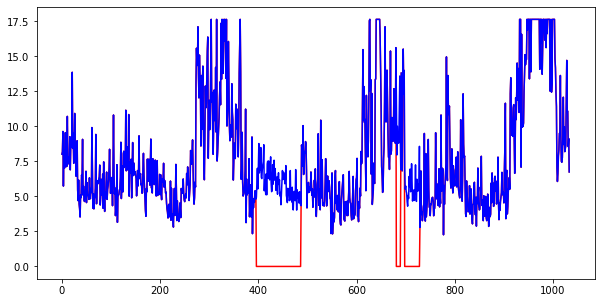

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(df.iloc[1][:-2].to_list(), color='red')
plt.plot(new_rows[1], color='blue')

In [37]:
# Non-MP version
#new_rows = list(map(impute_row, list(range(2))))#list(range(len(df)))) 

def edtwbi(x, start_index, end_index):
    len_gap = end_index - start_index
    
    Qa = x[end_index:end_index+len_gap]
    Qb = x[start_index-len_gap:start_index]
    
    if end_index + len_gap > len(x):
        apply_dtwbi_below(x, start_index, end_index) # only dtwbi in other direction
        
    elif start_index-len_gap < 0:
        apply_dtwbi_above(x, start_index, end_index) # only dtwbi in other direction
     
    Da = x[end_index+len_gap:]
    Db = x[:start_index-len_gap]

    Qas_start = dtwbi(Da, Qa, len_gap)
    Qbs_start = dtwbi(Db, Qb, len_gap)
    
    #Qas = x[Qas_start:Qas_start+len_gap]
    #Qbs = x[Qbs_start:Qbs_start+len_gap]    
    
    if Qas_start-len_gap < 0:
        refA = x[Qas_start:Qas_start+len_gap] # = Qa
        refB = x[Qbs_start+len_gap:Qbs_start+2*len_gap] # Next window of Qbs
        
    elif Qbs_start+2*len_gap > len(x):
        refA = x[Qas_start-len_gap:Qas_start] # Previous window of Qas
        refB = x[Qbs_start:Qbs_start+len_gap] # = Qb
        
    else:
        refA = x[Qas_start-len_gap:Qas_start] # Previous window of Qas
        refB = x[Qbs_start+len_gap:Qbs_start+2*len_gap] # Next window of Qbs
        
    return np.mean([np.array(refA), np.array(refB)], axis = 0)